## 3. Modeling TF-IDF x LSTM

### 3.1 Importing the Libraries 

In [18]:
import pickle
import os 
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Embedding, LSTM, Input, Concatenate, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW 
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### 3.2 Define the Parameter

In [2]:
VOCAB_SIZE = 5000
TFIDF_FEATURES = 5000
MAX_LEN = 200
MODEL_SAVE_PATH = "../models/lstm_model.keras"

### 3.2 Load the Dataset

In [3]:
# Training
X_train_pad   = pickle.load(open("../dataset/processed/02_after_FE/X_train_pad.pkl", "rb"))
X_train_tfidf = pickle.load(open("../dataset/processed/02_after_FE/X_train_tfidf.pkl", "rb"))
y_train       = pickle.load(open("../dataset/processed/02_after_FE/y_train.pkl", "rb"))

# Validation
X_val_pad     = pickle.load(open("../dataset/processed/02_after_FE/X_val_pad.pkl", "rb"))
X_val_tfidf   = pickle.load(open("../dataset/processed/02_after_FE/X_val_tfidf.pkl", "rb"))
y_val         = pickle.load(open("../dataset/processed/02_after_FE/y_val.pkl", "rb"))

# Test
X_test_pad    = pickle.load(open("../dataset/processed/02_after_FE/X_test_pad.pkl", "rb"))
X_test_tfidf  = pickle.load(open("../dataset/processed/02_after_FE/X_test_tfidf.pkl", "rb"))
y_test        = pickle.load(open("../dataset/processed/02_after_FE/y_test.pkl", "rb"))

### 3.3 Konversi Data Type

In [4]:
# Input Sequence (X_pad) for Embedding Layer
X_train_pad = np.array(X_train_pad, dtype='int32')
X_val_pad   = np.array(X_val_pad, dtype='int32')   # BARU
X_test_pad  = np.array(X_test_pad, dtype='int32')

# Input TFIDF and Label
X_train_tfidf = np.array(X_train_tfidf, dtype='float32')
X_val_tfidf   = np.array(X_val_tfidf, dtype='float32') # BARU
X_test_tfidf  = np.array(X_test_tfidf, dtype='float32')

y_train = np.array(y_train, dtype='float32')
y_val   = np.array(y_val, dtype='float32')         # BARU
y_test  = np.array(y_test, dtype='float32')

### 3.4 Check Array Dimension

In [5]:
print(f"Shape X_train_pad: {X_train_pad.shape}")
print(f"Shape X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train_pad: (30816, 200)
Shape X_train_tfidf: (30816, 5000)
Shape y_train: (30816,)
Shape y_test: (2089,)


In [6]:
# Assertion check
assert X_train_pad.shape[0] == X_train_tfidf.shape[0] == y_train.shape[0], \
    "Mismatch: jumlah sample antara sequence, tfidf, dan label tidak sama!"

assert X_test_pad.shape[0] == X_test_tfidf.shape[0] == y_test.shape[0], \
    "Mismatch: jumlah sample test tidak sama!"

### 3.4 Build LSTM Model with TF-IDF

In [7]:
# Sequence Branch
input_seq = Input(shape=(MAX_LEN,), name='input_sequence')

x = Embedding(input_dim=VOCAB_SIZE, output_dim=64)(input_seq) 

# # On x-axis, add kernel_regularizer = l2(0.01)
x = LSTM(32, kernel_regularizer=l2(0.01))(x) 
x = Dropout(0.5)(x) 

# TF-IDF Branch
input_tfidf = Input(shape=(TFIDF_FEATURES,), name='input_tfidf') 

# # On y-axis, add kernel_regularizer = l2(0.01) in dense
y = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(input_tfidf) 
y = Dropout(0.5)(y) 

# Concate
combined = Concatenate()([x, y])

# Combined Dense Layer
# On z-axis, add kernel_regularizer = l2(0.01)
z = Dense(32, activation="relu", kernel_regularizer=l2(0.01))(combined) 
z = Dropout(0.5)(z) 

output_layer = Dense(1, activation="sigmoid")(z)

# Define model
model = Model(inputs=[input_seq, input_tfidf], outputs=output_layer)

# Reduce the Learning Rate (add zero to one) to make it smooth
optimizer = AdamW(learning_rate=0.00001, weight_decay=0.004)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer, 
    metrics=['accuracy']
)
print(model.summary())

I0000 00:00:1763623039.841390   66836 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1200 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │    320,000 │ input_sequence[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_tfidf         │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     12,416 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     80,016 │ input_tfidf[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,568 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 414,033 (1.58 MB)

 Trainable params: 414,033 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

None


### 3.5 Define Callbacks

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

### 3.6 Training

In [9]:
history = model.fit(
    [X_train_pad, X_train_tfidf],
    y_train,
    validation_data=([X_val_pad, X_val_tfidf], y_val), 
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


2025-11-20 14:17:23.832745: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


482/482 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5230 - loss: 2.1642 - val_accuracy: 0.9229 - val_loss: 2.0639
Epoch 2/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5777 - loss: 1.9891 - val_accuracy: 0.9344 - val_loss: 1.8952
Epoch 3/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6119 - loss: 1.8413 - val_accuracy: 0.9382 - val_loss: 1.7369
Epoch 4/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6484 - loss: 1.6764 - val_accuracy: 0.9368 - val_loss: 1.3247
Epoch 5/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8040 - loss: 1.4425 - val_accuracy: 0.9617 - val_loss: 1.1125
Epoch 6/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8834 - loss: 1.3178 - val_accuracy: 0.9727 - val_loss: 1.0361
Epoch 7/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9281 - loss: 1.2295 - val_accuracy: 0.9607 - val_loss: 0.9377
Epoch 8/100
482/482 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9442 - loss: 1.1578 - val_acc

### 3.7 Evaluation

In [10]:
loss, acc = model.evaluate([X_test_pad, X_test_tfidf], y_test, verbose=1)
print(f"\nAkurasi Test (LSTM + TF-IDF): {acc:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9761 - loss: 0.1591

Akurasi Test (LSTM + TF-IDF): 0.9761


In [19]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print("\n" + "="*40)
print("   DETAIL EVALUASI: LSTM + TF-IDF")
print("="*40)
print(f"Akurasi   : {acc:.4f}")
print(f"Presisi   : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("="*40)


   DETAIL EVALUASI: LSTM + TF-IDF
Akurasi   : 0.9761
Presisi   : 0.8304
Recall    : 0.8712
F1-Score  : 0.8503


#### 3.7.1 Training and Validation Loss

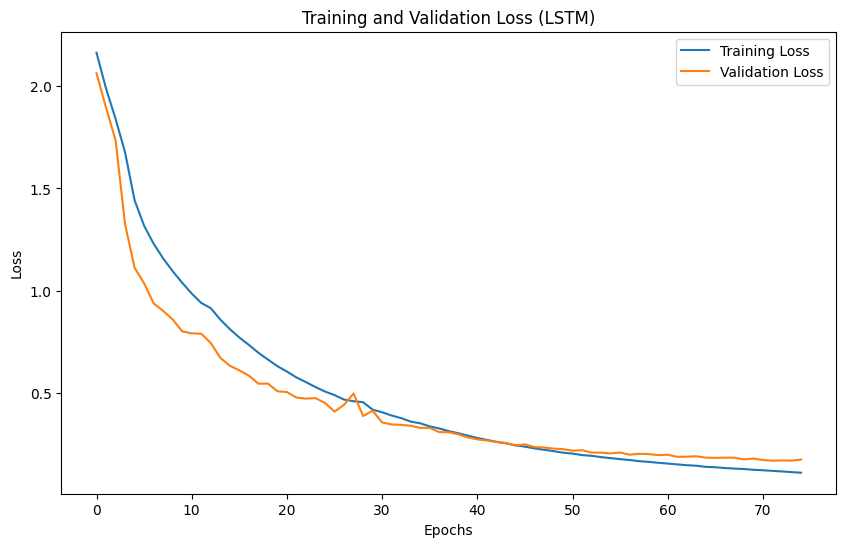

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 3.7.2 Confusion Matrix

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


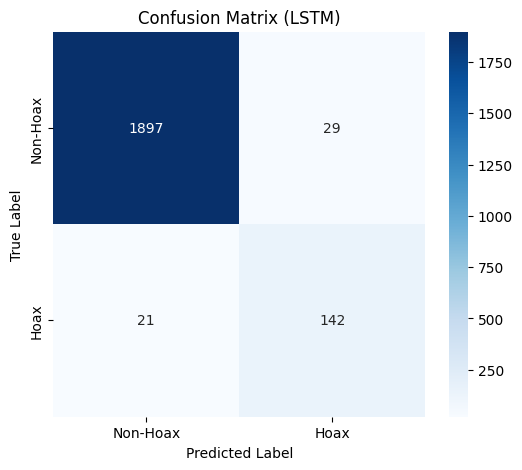

              precision    recall  f1-score   support

    Non-Hoax       0.99      0.98      0.99      1926
        Hoax       0.83      0.87      0.85       163

    accuracy                           0.98      2089
   macro avg       0.91      0.93      0.92      2089
weighted avg       0.98      0.98      0.98      2089



In [12]:
y_pred_prob = model.predict([X_test_pad, X_test_tfidf])
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Hoax', 'Hoax'],
            yticklabels=['Non-Hoax', 'Hoax'])
plt.title('Confusion Matrix (LSTM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Non-Hoax', 'Hoax']))

### 3.8 Save Model

In [13]:
os.makedirs("../models", exist_ok=True) 
model.save(MODEL_SAVE_PATH)
print("Model LSTM saved to:", MODEL_SAVE_PATH)

Model LSTM saved to: ../models/lstm_model.keras


### 3.9 Addition

In [14]:
best_epoch_index = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_epoch_index]

print(f"Model mulai menghafal sekitar epoch: {best_epoch_index + 1}")
print(f"Validation Loss terendah (Best Epoch): {best_val_loss:.4f}")

Model mulai menghafal sekitar epoch: 72
Validation Loss terendah (Best Epoch): 0.1681
